# https://www.kaggle.com/syamkakarla/traffic-sign-classification-using-resnet

# Taffic Sign Classification

Traffic Sign Classification Using **Convolutional Neural Networks(CNNs)**

![taffic_signs](https://www.linkpicture.com/q/Capture_39.jpg)

In [1]:
import numpy as np
import pandas as pd
import os
# !ls -l /kaggle/input/traffic-signs-classification # GTSRB - German Traffic Sign Recognition Benchmark

## Importing Libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.1.0


## Reading Data of Class Labels

In [3]:
# path = '/kaggle/input/traffic-signs-classification'
# lab = pd.read_csv('/kaggle/input/traffic-signs-classification/labels.csv')

path = '../input/traffic-sign/Traffic_sign'
lab = pd.read_csv('../input/traffic-sign/Traffic_sign/labels.csv')

## Visualizing countplot of the classes

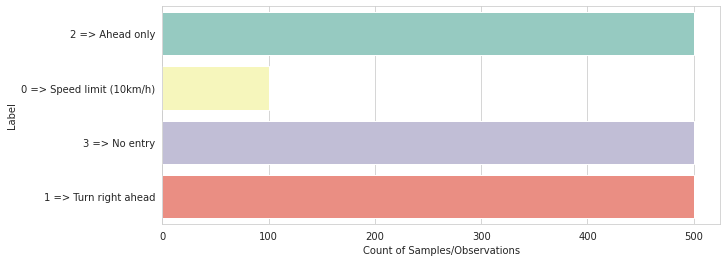

In [4]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (10, 4))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

## Reading Image Data

In [5]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())
print("nb_classes:{}".format(nb_classes))

# datagen = ImageDataGenerator()
# data = datagen.flow_from_directory('../input/traffic-signs-classification/myData',
#                                     target_size=(32, 32),
#                                     batch_size=73139,
#                                     class_mode='categorical',
#                                     shuffle=True ) # 73139 

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('../input/traffic-sign/Traffic_sign/myData',
                                    target_size=(32, 32),
                                    batch_size=1600,
                                    class_mode='categorical',
                                    shuffle=True )

nb_classes:4
Found 1600 images belonging to 4 classes.


In [6]:
X , y = data.next()

In [7]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(1600, 32, 32, 3)
Labels shape :(1600, 4)


## Sample Images of Dataset

In [8]:
for i in d: print("Label:",i)

Label: 2 => Ahead only
Label: 0 => Speed limit (10km/h)
Label: 3 => No entry
Label: 1 => Turn right ahead


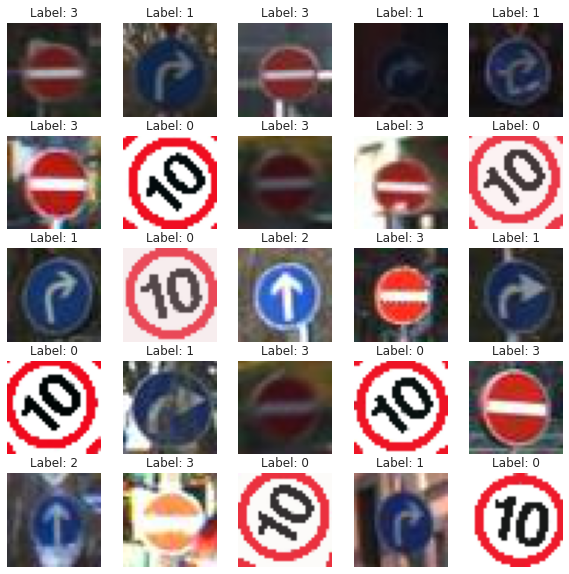

In [9]:
fig, axes = plt.subplots(5,5, figsize=(10,10))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))
    


## Dividing data into **train** and **test** in the split percentage of 80:20

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [11]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (1280, 32, 32, 3)
Test Shape : (320, 32, 32, 3)


## Customising ResNet50 Model  

In [12]:
# def resnet_model():
#     resnet = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape= (img_rows,img_cols,img_channels))
#     x = resnet.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.5)(x)
#     predictions = Dense(nb_classes, activation= 'softmax')(x)

#     model = Model(inputs = resnet.input, outputs = predictions)
#     return model

# model = resnet_model()
# # model.summary()

## Customising Vgg16 Model  

In [13]:
def vgg16_model():
    vgg16 = VGG16(include_top=False, weights=None, input_shape= (img_rows,img_cols,img_channels))

    x = vgg16.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3) (x)
    x = Dense(128) (x)
    x = LeakyReLU(alpha=0.2) (x)
    x = GaussianDropout(0.4) (x)
    predictions = Dense(nb_classes,activation="softmax", dtype='float32')(x)

    model = Model(inputs = vgg16.input, outputs = predictions)
    return model

model = vgg16_model()
# model.summary()

## Making the model

In [14]:
# model = Sequential([    
#     Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(img_rows,img_cols,img_channels)),
#     Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#     MaxPool2D(pool_size=(2, 2)),
#     BatchNormalization(axis=-1),
    
#     Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#     Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
#     MaxPool2D(pool_size=(2, 2)),
#     BatchNormalization(axis=-1),
    
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(rate=0.5),
    
#     Dense(nb_classes, activation='softmax')
# ])

## Visualising Model Architecture

In [15]:
# plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

## Compiling the Model

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Creating Callbacks

In [17]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')


## Fitting Model with Data

In [18]:
n_epochs = 30
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
                     validation_data = (X_test, y_test), 
                     callbacks = [model_check, early, reduce_lr, csv_logger])

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 5s 4ms/sample - loss: 1.3847 - accuracy: 0.3141 - val_loss: 1.1963 - val_accuracy: 0.3219
Epoch 2/30
1280/1280 [==============================] - 1s 617us/sample - loss: 1.2187 - accuracy: 0.3859 - val_loss: 1.1904 - val_accuracy: 0.3063
Epoch 3/30
1280/1280 [==============================] - 1s 616us/sample - loss: 1.2108 - accuracy: 0.3719 - val_loss: 1.1842 - val_accuracy: 0.3219
Epoch 4/30
1280/1280 [==============================] - 1s 987us/sample - loss: 1.2082 - accuracy: 0.4633 - val_loss: 0.8962 - val_accuracy: 0.6062
Epoch 5/30
1280/1280 [==============================] - 1s 986us/sample - loss: 0.7121 - accuracy: 0.6258 - val_loss: 0.4328 - val_accuracy: 0.7031
Epoch 6/30
1280/1280 [==============================] - 1s 625us/sample - loss: 0.7183 - accuracy: 0.6242 - val_loss: 0.5570 - val_accuracy: 0.6687
Epoch 7/30
1280/1280 [==============================] - 1s 615us/sa

In [19]:
# Saving the model
model.save('TSC_model.h5')

In [20]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy:%.5f'%(acc))
print('Loss    :%.5f'%(loss))

320/320 [==============================] - 0s 222us/sample - loss: 0.3524 - accuracy: 0.8375
Accuracy:0.83750
Loss    :0.35238


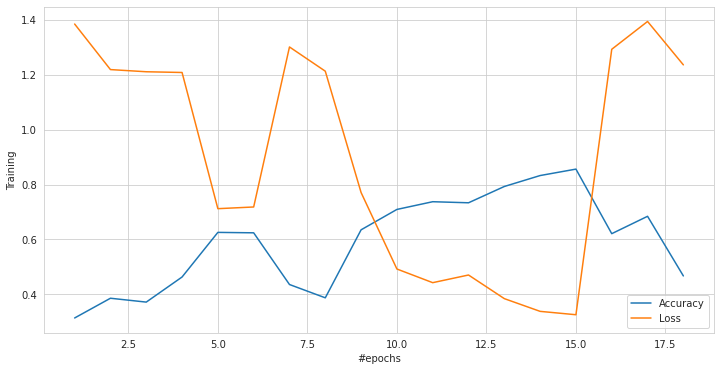

In [21]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

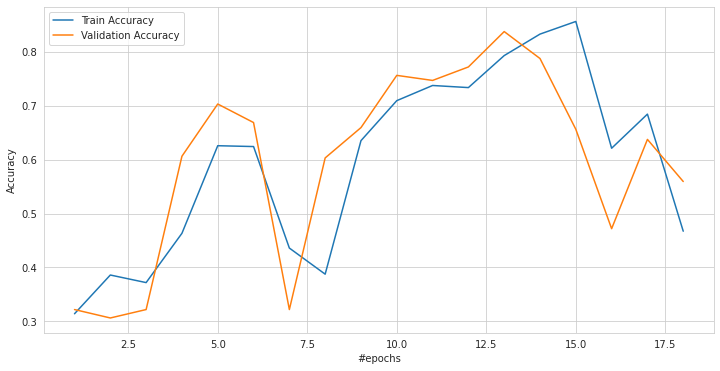

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

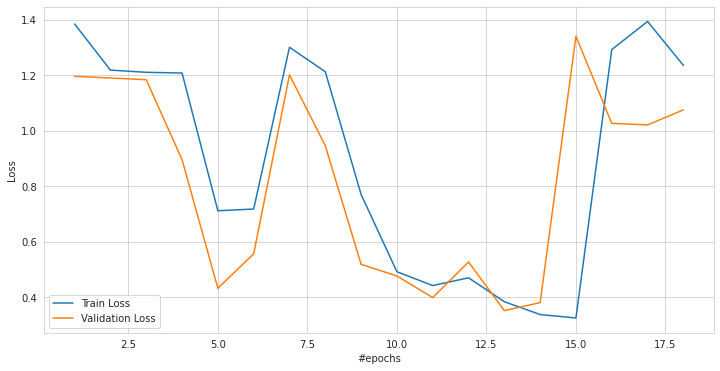

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train Loss')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

## Predict class labels of the test data

In [24]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

CPU times: user 196 ms, sys: 2.49 ms, total: 198 ms
Wall time: 188 ms


## Classification Report

In [25]:
labels = [class_labels[i] for i in range(nb_classes)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

                      precision    recall  f1-score   support

Speed limit (10km/h)       1.00      1.00      1.00        22
    Turn right ahead       0.71      0.81      0.75        98
          Ahead only       0.79      0.71      0.75       103
            No entry       1.00      0.97      0.98        97

            accuracy                           0.84       320
           macro avg       0.87      0.87      0.87       320
        weighted avg       0.84      0.84      0.84       320



## Confusion Matrix

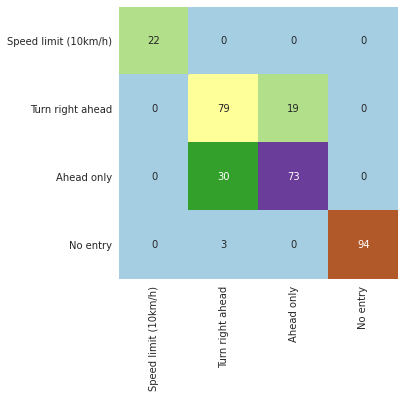

In [26]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels);

## Classwise Accuracy

In [27]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label':[class_labels[i] for i in range(nb_classes)], 'Accuracy': classwise_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])
cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='pink')

Class_Label,Accuracy
Speed limit (10km/h),100.00
Turn right ahead,80.61
Ahead only,70.87
No entry,96.91


## Finally, Lets see the predictions of **unseen data**

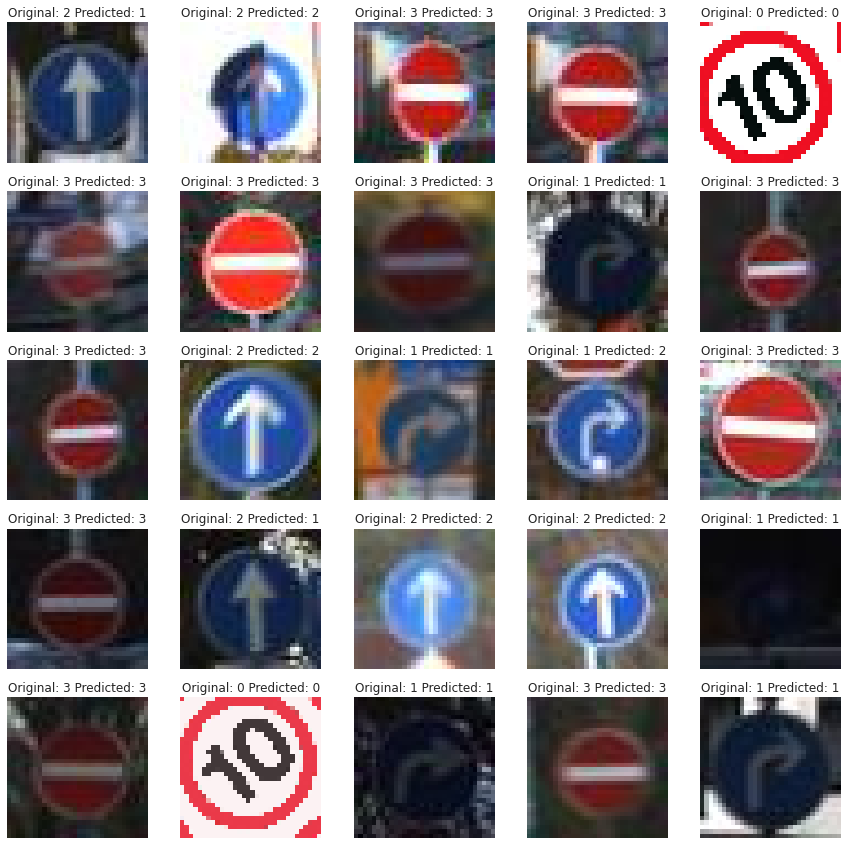

In [28]:
fig, axes = plt.subplots(5,5, figsize=(15,15))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

--- 